In [7]:
%pip install --upgrade pyldavis



Note: you may need to restart the kernel to use updated packages.


In [1]:
import openai
import os

# create openai client
client = openai.OpenAI(api_key=os.getenv("OPENAI_API_KEY"))

# use model gpt-3.5-turbo-1106
def sendGPT3Request(system_message):
    response = client.chat.completions.create(
        # model="gpt-3.5-turbo-1106",
        model="gpt-4-0125-preview",
        response_format={ "type": "json_object" },
        messages=[
         {"role": "system", "content": system_message}
        ]   
    )
    
    return response.choices[0].message.content

# convert prompts to string
def promptsToString(prompts):
  output_string = ""
  for i, obj in enumerate(prompts, start=1):
    output_string += f"{i}. {obj['title']}\n{obj['description']}\n\n"
  return output_string

In [2]:
import json
import glob


# load prompts from prompts.json file
with open('prompts.json', 'r') as f:
    prompts = json.load(f)

def loadFiles(sub_path = "/chat/"):
    # load all txt in data into a list of objects {id: text, text: text}
    textFiles = []
    for file in glob.glob('../data/**/videos/*.txt', recursive=True):
        with open(file, 'r') as f:
            filename = file.split('/')[-1].split('.')[0]
            textFiles.append({'id': filename, 'text': f.read(), 'folder': file.split('/')[-3]})

    # load all json in data into a list of objects {id: text, data: dict}
    jsonFiles = []
    for file in glob.glob('../data/**/videos/*.json', recursive=True):
        with open(file, 'r') as f:
            filename = file.split('/')[-1].split('.')[0]
            jsonFiles.append({'id': filename, 'data': f.read()})
            

    # merge text and json files into one list of objects {id: text, text: text, title: text }
    files = []
    for textFile in textFiles:
        for jsonFile in jsonFiles:
            if textFile['id'] == jsonFile['id']:
                files.append({'id': textFile['id'], 'text': textFile['text'], 'title': json.loads(jsonFile['data'])['desc'], 'folder': textFile['folder']})

    # load all files in data/**/chat/*.txt into a list of objects {id: text, text: text}
    chatFiles = []
    for file in glob.glob(f"../data/**{sub_path}*.json", recursive=True):
        with open(file, 'r') as f:
            filename = file.split('/')[-1].split('.')[0]
            chatFiles.append({'id': filename, 'text': f.read()})

    # filter out files that are already in chatFiles
    files = [file for file in files if file['id'] not in [chatFile['id'] for chatFile in chatFiles]]

    print(f"Number of files to process: {len(files)}")
    print(f"Number of chat files: {len(chatFiles)}")
    print(f"Number of text files: {len(textFiles)}")

    return files


# create chat folder inside each folder if it does not exist
def createDirectoryies(files):
    # get all differnet folders
    folders = list(set([file['folder'] for file in files]))

    # create chat folder inside each folder if it does not exist
    for folder in folders:
        if not os.path.exists(f'../data/{folder}/chat/topic/v3'):
            os.makedirs(f'../data/{folder}/chat/topic/v3')
            print(f"Created folder ../data/{folder}/chat/topic/v3")
        else:
            print(f"Folder ../data/{folder}/chat/topic/v3 already exists")



In [21]:
# Classify the tiktok videos based on the prompts inside prompts.json file and save the output in ../data/{folder}/chat/{id}.json

files = loadFiles(sub_path= "/chat/")
createDirectoryies(files)

# send request to gpt3 for each file
counter = 0
for file in files:
    counter += 1
    print(f"Processing file {counter}/{len(files)}")
    
    system_message =  f"Act as a classifier for tiktok videos. You have to answer the following questions:\n{promptsToString(prompts)}\nOutput in the following json format:\n{{\n\t\"1\": \"Original\",\n\t\"2\": \"Game\",\n\t\"3\": \"Branding\",\n\t\"4\": \"Both\",\n\t\"5\": \"Unknown\"\n}}"
    user_message = f"Video description: {file['title']}\nVideo transcript: {file['text']}"
    # send request to gpt3
    response = sendGPT3Request(system_message, user_message)
    # save response to file
    with open(f"../data/{file['folder']}/chat/{file['id']}.json", 'w') as f:
        f.write(response)


Number of files to process: 0
Number of chat files: 1623
Number of text files: 1623


In [32]:
sub_path = "/chat/topic/v1/"
files = loadFiles(sub_path= sub_path)



# send request to gpt3 for each file
counter = 0
for file in files:
    counter += 1
    print(f"Processing file {counter}/{len(files)}")
    
    existing_topics = [
    {"id": 1, "text": "Kurs der Bundesregierung im Ukraine-Krieg", "matched_count": 0},
    {"id": 2, "text": "Sicherung der Energieversorgung?", "matched_count": 0},
    {"id": 3, "text": "Flüchtlings- und Zuwanderungspolitik", "matched_count": 0},
    {"id": 4, "text": "Entlastung der Bürger wegen steigender Preise?", "matched_count": 0},
    {"id": 5, "text": "Haushalts- und Finanzpolitik", "matched_count": 0},
    {"id": 6, "text": "Verkehrspolitik", "matched_count": 0},
    {"id": 7, "text": "Maßnahmen zum Klimaschutz", "matched_count": 0},
    {"id": 8, "text": "Zuwanderung/ Flucht", "matched_count": 0},
    {"id": 9, "text": "Bewaffnete Konflikte/ Frieden/ Außenpolitik", "matched_count": 0},
    {"id": 10, "text": "Rente/ Alterssicherung", "matched_count": 0},
    {"id": 11, "text": "Wirtschaft", "matched_count": 0},
    {"id": 12, "text": "Inflation/ steigende Preise/ Energiepreise", "matched_count": 0},
    {"id": 13, "text": "Steuern/ Abgaben", "matched_count": 0}
]

    existing_topics_str = str(existing_topics)

#     system_message = f"""Classify TikTok videos by topics. Available topics: {existing_topics_str}. If a video's topic doesn't match any of the existing topics, either rephrase an existing topic to include the video's theme or create a new topic. Exclude videos on niche topics. Output the classification in JSON format with arrays for rephrased topics, matched topics, and new topics.
# The maximum number of topics is 30 and topics with more matched videos should be rephrased more carefully.

# Example Output Format:
# {{
# "rephrased_topics": [
#     {{"id": existing_topic_id, "new_text": "Rephrased Topic"}}
# ],
# "matched_topics": [
#     matched_topic_id
# ],
# "new_topic": [
#     {{"id": new_topic_id, "text": "New Topic Description"}}
# ]
# }}
#     """

    system_message = f"""
Fassen Sie TikTok-Videos anhand des Videotranskripts zu politischen Themen zusammen.

Video-Transkript: {file['text']}

Beispiel für das Ausgabeformat in JSON:
{{topic": "Beschreibung des neuen Themas"}}
"""


    user_message = f"Video transcript: {file['text']}"
    # send request to gpt3
    response = sendGPT3Request(system_message)
    # print(system_message)
    # print(response)
    # save response to file
    with open(f"../data/{file['folder']}{sub_path}{file['id']}.json", 'w') as f:
        f.write(response)

Number of files to process: 1623
Number of chat files: 0
Number of text files: 1623
Processing file 1/1623
Processing file 2/1623
Processing file 3/1623
Processing file 4/1623
Processing file 5/1623
Processing file 6/1623
Processing file 7/1623
Processing file 8/1623
Processing file 9/1623
Processing file 10/1623
Processing file 11/1623
Processing file 12/1623
Processing file 13/1623
Processing file 14/1623
Processing file 15/1623
Processing file 16/1623
Processing file 17/1623
Processing file 18/1623
Processing file 19/1623
Processing file 20/1623
Processing file 21/1623
Processing file 22/1623
Processing file 23/1623
Processing file 24/1623
Processing file 25/1623
Processing file 26/1623
Processing file 27/1623
Processing file 28/1623
Processing file 29/1623
Processing file 30/1623
Processing file 31/1623
Processing file 32/1623
Processing file 33/1623
Processing file 34/1623
Processing file 35/1623
Processing file 36/1623
Processing file 37/1623
Processing file 38/1623
Processing fi

In [42]:
# load all files in data/**/chat/topic/v1/*.json into a list of topics
topics = []
for file in glob.glob('../data/**/chat/topic/v1/*.json', recursive=True):
    with open(file, 'r') as f:
        filename = file.split('/')[-1].split('.')[0]
        map = json.loads(f.read())
        try :
            topics.append({'id': filename, 'topic': map['topic']})
        except:
            print(f"Error in file {filename} with content {map}")

with open(f"../data/topics.json", 'w') as f:
    f.write(json.dumps(topics))
        

# # group topics in groups of 20 and send them to gpt3 to group them groups of 10
# grouped_topics = []
# for i in range(0, len(topics), 20):
#     grouped_topics.append(topics[i:i+20])

# # send request to gpt3 for each group
# counter = 0
# for group in grouped_topics[:1]:
#     counter += 1
#     print(f"Processing group {counter}/{len(grouped_topics)}")
    
#     system_message = f"""Summarize the topics of the TikTok videos into 10 topics. The topics are: {group}.
#     If this is not possible with 10 topics, assign them to topic "Other". You goal is to summarize the topics of the videos as good as possible and using "Other" as little as possible. Reformulate existing topics to cover more videos.
    
#     Output the topics in JSON format with the following format:
#     [
#         {{ "topic": "Topic 1", "ids": [topic_ids] }},
#     ]
#     """

#     user_message = f"Topics: {group}"
#     # send request to gpt3
#     response = sendGPT3Request(system_message)
#     print(system_message)
#     print(response)
#     # save response to file
#     with open(f"../data/topic/v1/{counter}.json", 'w') as f:
#         f.write(response)



Error in file 7282682585652743457 with content {}


In [54]:
sub_path = "/chat/topic/v2/"
files = loadFiles(sub_path= sub_path)

# send request to gpt3 for each file
counter = 0
for file in files[1:]:
    counter += 1
    print(f"Processing file {counter}/{len(files)}")
    
    system_message = f"""
Sie erhalten ein Transkript eines Videos, und Ihre Aufgabe ist es, eine Liste von Wörtern des Transkripts zurückzugeben, die sich auf das Thema des Videos beziehen.

Beispiel für das Ausgabeformat in JSON:
{{"list": ["Wort1", "Wort2", "Wort3"]}}

Transkript: {file['text']}
"""

    # send request to gpt3
    response = sendGPT3Request(system_message)
    # print(response)
    # print(system_message)
    
    # save response to file
    with open(f"../data/{file['folder']}{sub_path}{file['id']}.json", 'w') as f:
        f.write(response)


Number of files to process: 1
Number of chat files: 1622
Number of text files: 1623


In [55]:
# load all files in data/**/chat/topic/v2/*.json into a list of topics
topics = []
for file in glob.glob('../data/**/chat/topic/v2/*.json', recursive=True):
    with open(file, 'r') as f:
        filename = file.split('/')[-1].split('.')[0]
        map = json.loads(f.read())
        try :
            topics.append({'id': filename, 'list': map['list']})
        except:
            print(f"Error in file {filename} with content {map}")


with open(f"../data/main_words.json", 'w') as f:
    f.write(json.dumps(topics))

1622
{'id': '7040353132622122245', 'list': ['Weihnachten', 'Christen-Nulz-Markt', 'Schaschlik', 'Christbaum-Hugel', 'Baum', 'Familie', 'Silvester', 'Heringssalat', 'Kindern', 'Böllern', 'Hunde']}


In [2]:
import xml.etree.ElementTree as ET

def extract_nachnamen(xml_file):
    # Parse the XML file
    tree = ET.parse(xml_file)
    root = tree.getroot()

    # Find all 'NACHNAME' elements and extract their text
    nachnamen = [nachname.text for nachname in root.findall(".//NACHNAME")]

    return nachnamen

# Example usage
xml_file = '/Users/leonardpries/Downloads/MdB-Stammdaten/MDB_STAMMDATEN.xml'
last_names = extract_nachnamen(xml_file)
# convert strings to lowercase
last_names = [last_name.lower() for last_name in last_names]

In [31]:
import json
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import pandas as pd


# Re-load the JSON file and extract text data for LDA analysis
file_path = '../data/main_words.json'

with open(file_path, 'r') as file:
    data = json.load(file)

# Combine the keywords into text documents for LDA analysis
# Assuming the relevant text is in the second key
key_for_text = list(data[0].keys())[1]
documents = [' '.join(item[key_for_text]) for item in data]

german_stop_words = stopwords.words('german') + ['afd', 'cdu', 'spd', 'fdp', 'union', 'csu', 'grüne', 'grünen', 'linke', 'linke', 'piraten', 'piratenpartei', 'partei', 'parteien'] + last_names

# Create a document-term matrix using CountVectorizer
vectorizer = CountVectorizer(stop_words=german_stop_words, max_features=100)
doc_term_matrix = vectorizer.fit_transform(documents)

# Extract feature names (words) to understand the topics better
feature_names = vectorizer.get_feature_names_out()

# Define and fit the LDA model for top 20 topics
num_topics_20 = 20
lda_20 = LatentDirichletAllocation(n_components=num_topics_20, random_state=0)
lda_20.fit(doc_term_matrix)

# Extracting the top 20 topics
topics_20 = {}
for topic_idx, topic in enumerate(lda_20.components_):
    topics_20[f"Topic {topic_idx + 1}"] = [feature_names[i] for i in topic.argsort()[:-11:-1]]

topics_20_df = pd.DataFrame(topics_20)

topic_distributions = lda_20.transform(doc_term_matrix)

# show the first 5 documents and their topic distributions
topic_distributions_df = pd.DataFrame(topic_distributions)

# Displaying top 10 rows of the first column
topics_20_df.head(10)






/Users/leonardpries/Documents/Uni/Seminar/tiktok_crawler/.conda/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['al', 'alabali', 'albring', 'ali', 'alten', 'altenloh', 'antwerpes', 'appuhn', 'asche', 'aschenberg', 'beek', 'bendt', 'bentrup', 'berge', 'bieberstein', 'bischoff', 'bläss', 'bode', 'bohlig', 'bosse', 'bott', 'bracht', 'brahmst', 'brömer', 'brücher', 'bubendorfer', 'bull', 'bulling', 'burgk', 'bähr', 'büllesheim', 'büning', 'cademartori', 'coreth', 'cramon', 'czesla', 'dailami', 'damerau', 'danielmeier', 'de', 'deipenbrock', 'delazari', 'desoi', 'diemer', 'dierig', 'dietert', 'dinges', 'djir', 'domscheit', 'donnersmarck', 'drobinski', 'drüggelte', 'dugnus', 'dujisin', 'däubler', 'dümpe', 'düren', 'eichstädt', 'eigenbrodt', 'elsweier', 'emmert', 'emre', 'engelbrecht', 'engler', 'englhardt', 'esser', 'fechter', 'feld', 'fibich', 'firnhaber'

,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7,Topic 8,Topic 9,Topic 10,Topic 11,Topic 12,Topic 13,Topic 14,Topic 15,Topic 16,Topic 17,Topic 18,Topic 19,Topic 20
0,bürger,kinder,fraktion,ukraine,bundesregierung,corona,politik,unterstützung,klimaschutz,menschen,arbeit,land,demokratie,soziale,deutschen,ausbildung,euro,regierung,bundestag,deutschland
1,ampel,gesellschaft,bundestag,krieg,gesetz,deutsche,inflation,bafög,leben,rente,bundeskanzler,bildung,cannabis,gerechtigkeit,parlament,fachkräftemangel,geld,frauen,abgeordnete,wirtschaft
2,steuern,familien,frieden,sicherheit,kommentare,abgeordneten,armut,bundeswehr,transkript,infrastruktur,bevölkerung,schule,legalisierung,frau,politiker,schulen,ticket,bürgergeld,fragen,energiepreise
3,bürgerinnen,einkommen,bundestagsfraktion,russland,identität,solidarität,jugendliche,krise,klima,staat,migration,impfen,gesundheit,armut,bundestag,israel,milliarden,co2,plenum,eu
4,europa,energien,politische,tiktok,bundestagsfraktion,impfen,kinder,eltern,video,zukunft,rentner,arbeit,politische,flüchtlinge,verantwortung,bildung,up,hartz,tiktok,musik
5,staat,respekt,abgeordneten,freiheit,migranten,tiktok,eltern,ampel,verantwortung,rentner,mindestlohn,flüchtlinge,jugendliche,plenum,abgeordneten,geld,mindestlohn,ampel,hartz,schuldenbremse
6,inflation,jugendliche,krieg,sanktionen,plenum,frieden,gesellschaft,frieden,energie,inflation,regierung,hartz,kinder,gesellschaft,kommentare,armut,gas,energien,abgeordneten,energie
7,politik,gas,plenum,putin,eltern,freiheit,staat,freiheit,schuldenbremse,gas,migranten,eltern,freiheit,freiheit,ukraine,frauen,armut,deutschland,inflation,flüchtlinge
8,schuldenbremse,eltern,migration,nato,wirtschaft,migranten,solidarität,inflation,energien,migranten,flüchtlinge,sicherheit,parlament,frieden,plenum,gesellschaft,plenum,sanktionen,kommentare,zukunft
9,flüchtlinge,migranten,europa,deutschland,freiheit,musik,bundestag,einkommen,israel,wirtschaft,rente,freiheit,zukunft,jugendliche,flüchtlinge,eu,inflation,zukunft,armut,inflation


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 100 samples in 0.001s...
[t-SNE] Computed neighbors for 100 samples in 0.069s...
[t-SNE] Computed conditional probabilities for sample 100 / 100
[t-SNE] Mean sigma: 13.872013
[t-SNE] KL divergence after 250 iterations with early exaggeration: 51.864296
[t-SNE] KL divergence after 1000 iterations: 0.242730


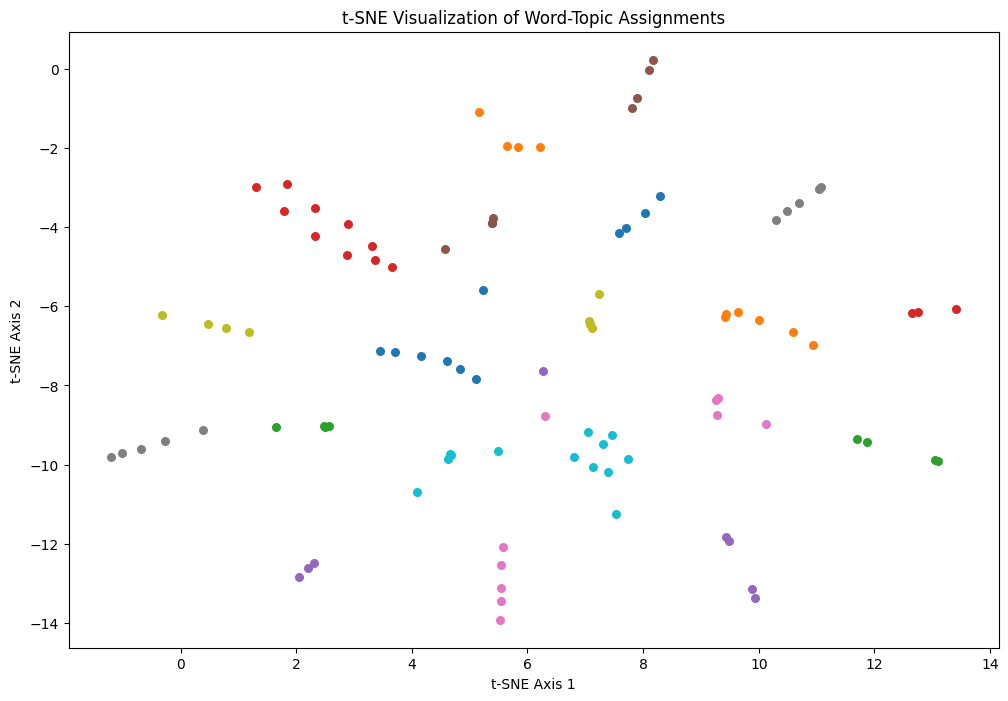

In [22]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np

# Re-creating the word-topic matrix from the LDA model
word_topic_matrix = lda_20.components_

# Identifying the dominant topic for each word
dominant_topic_per_word = np.argmax(word_topic_matrix, axis=0)

# Applying t-SNE for dimensionality reduction
tsne_model = TSNE(n_components=2, verbose=1, random_state=0, angle=.99, init='pca')
tsne_lda = tsne_model.fit_transform(word_topic_matrix.T)

# Creating a scatter plot
plt.figure(figsize=(12, 8))

# Assigning a color to each topic
colors = [f"C{i}" for i in range(num_topics_20)]

# Plotting each word in the 2D t-SNE space with its topic color
for i, word in enumerate(feature_names):
    topic = dominant_topic_per_word[i]
    plt.scatter(tsne_lda[i, 0], tsne_lda[i, 1], s=30, color=colors[topic], label=f"Topic {topic+1}" if i == 0 else "")

plt.title('t-SNE Visualization of Word-Topic Assignments')
plt.xlabel('t-SNE Axis 1')
plt.ylabel('t-SNE Axis 2')
# store plot in file
plt.savefig('lda2.png')
plt.show()



In [37]:
# extract topics from topics_20_df by column
topics = []
for i in range(0, len(topics_20_df.columns)):
    topics.append({'id': i, 'words': topics_20_df.iloc[:, i].tolist()})

results = []
for topic in topics:
    
    system_message = f"""
Sie erhalten eine Liste von Wörtern, die sich auf ein politisches Thema beziehen. 
Identifiziere die politische Thematik die am besten auf folgende Begriffe zutrifft. Die Formulierung muss nicht alle Wörter beinhalten und sollte ein politisches Thema darstellen.
Wenn die Wörter mehere Themen beschreiben, dann wähle das Thema, das am besten passt.

Beispiel für das Ausgabeformat in JSON:
{{"topic": "Thema"}}

Wörter: {topic['words']}

"""
      
    # send request to gpt3
    response = sendGPT3Request(system_message)
    
    results.append({'id': topic['id'], 'words': topic['words'], 'result': response})

with open(f"../data/topics_gpt_v2.json", 'w') as f:
    f.write(json.dumps(results))
      


In [13]:
# GPT topic summary "Single Prompt" approach
# read all files in folder ../data/**/chat/topic/v1/*.json into a list of topics
import glob
import json

topics = []

for file in glob.glob('../data/**/chat/topic/v1/*.json', recursive=True):

    with open(file, 'r') as f:
        filename = file.split('/')[-1].split('.')[0]
        map = json.loads(f.read())
        try :
            topics.append(map['topic'])
        except:
            print(f"Error in file {filename} with content {map}")

# propmt gpt create a list of the top 30 topics
system_message = f"""
Sie erhalten eine Liste von Themen aus TikTok-Videos der aktuellen regierenden politischen Parteien in Deutschland.
Erstellen Sie eine Liste von Themen, die die Themen in der Liste zusammenfassen. Die Liste sollte nicht mehr als 30 Themen enthalten.
Einzelne ausnahme Themen können in der Liste "Andere" zusammengefasst werden.
der Output sollte in folgendem JSON Format sein:
[
    {{ "topic": "Thema 1"}},
]

Themen: {topics}
"""

# send request to gpt4
response = sendGPT3Request(system_message)

# save response to file
with open(f"../data/gpt_single_prompt_topics_v2.json", 'w') as f:
    f.write(response)

Error in file 7282682585652743457 with content {}


In [20]:
# numerate topics
topics = []

with open(f"../data/gpt_single_prompt_topics_v2.json", 'r') as f:
    topics = json.loads(f.read())["topics"]

topics = [{f"{i}":topic['topic']} for i, topic in enumerate(topics)]

with open(f"../data/gpt_single_prompt_topics_v2_numerated.json", 'w') as f:
    f.write(json.dumps(topics))


In [4]:
# Video to topic mapping
# Topics: ../data/gpt_single_prompt_topics_v2_numerated.json
# Videos: ../data/**/videos/*.txt
sub_path = "/chat/topic/v3/"
files = loadFiles(sub_path= sub_path)
# createDirectoryies(files)

topics = []
with open('../data/gpt_single_prompt_topics_v2_numerated.json', 'r') as f:
    topics = json.loads(f.read())


# send request to gpt3 for each file
counter = 0
for file in files:
    counter += 1
    print(f"Processing file {counter}/{len(files)}")
    
    system_message = f"""
Sie erhalten ein Transkript eines Videos, und Ihre Aufgabe ist es, das Video einer Liste von Themen zuzuordenen.
Es muss ein Thema aus der Liste gewählt werden. Wenn das Video nicht zu einem Thema passt, wählen Sie "Andere".
In den Subthemen können Sie weitere Themen hinzufügen, die neben dem Hauptthema des Videos behandelt werden.
Die Antwort soll nur die ID des Themas und die IDs der Subthemen enthalten!

Beispiel für das Ausgabeformat in JSON:
{{"topic": "Thema-ID", "subtopics": ["Subthema-ID", "Subthema-ID"]}}

Themen: {topics}

Transkript: {file['text']}
"""

    # send request to gpt4
    response = sendGPT3Request(system_message)
    
    # save response to file
    with open(f"../data/{file['folder']}{sub_path}{file['id']}.json", 'w') as f:
        f.write(response)

Number of files to process: 0
Number of chat files: 1623
Number of text files: 1623


In [20]:
from moviepy.editor import VideoFileClip

# Determine the duration of a video
# video_path: path to the video file
# return: duration of the video in seconds
def getVideoDuration(video_path):
    # Load the video file
    clip = VideoFileClip(video_path)

    # Get the duration of the video in seconds
    duration = clip.duration
    return duration
    
# Determine the category of the video duration
# duration: duration of the video in seconds
# return: [0-10, 10-15, 15-20, >20]
def getVideoDurationCategory(duration):
    if duration < 10:
        return "0-10"
    elif duration < 15:
        return "10-15"
    elif duration < 20:
        return "15-20"
    else:
        return ">20"
    

def extractRelevantInfo(file):
    with open(file, 'r') as f:
        filename = file.split('/')[-1].split('.')[0]
        map = json.loads(f.read())
        
        mp4_file = f"{file.replace('.json', '.mp4')}"
        video_duration = getVideoDuration(mp4_file)
        
        transcript = ""
        txt_file = f"{file.replace('.json', '.txt')}"
        with open(txt_file, 'r') as t:
            transcript = t.read()
        words_per_second = len(transcript.split()) / video_duration       

        # load video topics
        with open(f"../data/{file.split('/')[-3]}/chat/topic/v3/{filename}.json", 'r') as t:
            video_topics = json.loads(t.read())
        
        try :
            return {filename: {"group": map.get("author").get("uniqueId"), "createTime": map.get("createTime"), "textExtraCount": len(map.get("textExtra", "")), "challengesCount": len(map.get("challenges", "")), "descLength": len(map.get("desc", "")), "publicMusic": map.get("music").get("authorName") != map.get("author").get("nickname"), "collectCount": map.get("stats").get("collectCount"), "commentCount": map.get("stats").get("commentCount"), "diggCount": map.get("stats").get("diggCount"), "shareCount": map.get("stats").get("shareCount"), "playCount": map.get("stats").get("playCount"), "duration": video_duration, "wordsPerSecond": words_per_second, "topics": video_topics}}
        except Exception as e:
            print(f"Error in file {filename} Error: {e}")


In [21]:
# Collect all important infos for each video in one file
import glob
import json
from tqdm import tqdm

video_infos = []

# List all files matching the pattern
files = glob.glob('../data/**/videos/*.json', recursive=True)

# Initialize the progress bar
for file in tqdm(files, desc="Processing files"):
    try:
        video_infos.append(extractRelevantInfo(file))
    except Exception as e:
        # Print errors without breaking the progress bar
        tqdm.write(f"Error in file {file} Error: {e}")

print(f"Number of video infos: {len(video_infos)}")

with open(f"../data/video_data_summary.json", 'w') as f:
    f.write(json.dumps(video_infos))

        

Processing files:  11%|█         | 172/1634 [00:56<10:33,  2.31it/s]

Error in file ../data/csuauftiktok/videos/7037060586512878854.json Error: MoviePy error: the file ../data/csuauftiktok/videos/7037060586512878854.mp4 could not be found!
Please check that you entered the correct path.


Processing files:  12%|█▏        | 188/1634 [01:01<07:57,  3.03it/s]

Error in file ../data/csuauftiktok/videos/6991858923632332037.json Error: MoviePy error: the file ../data/csuauftiktok/videos/6991858923632332037.mp4 could not be found!
Please check that you entered the correct path.


Processing files:  18%|█▊        | 296/1634 [01:36<07:26,  2.99it/s]

Error in file ../data/csuauftiktok/videos/6994464637144141061.json Error: MoviePy error: the file ../data/csuauftiktok/videos/6994464637144141061.mp4 could not be found!
Please check that you entered the correct path.


Processing files:  18%|█▊        | 302/1634 [01:37<06:29,  3.42it/s]

Error in file ../data/csuauftiktok/videos/6983221582059670790.json Error: [Errno 2] No such file or directory: '../data/csuauftiktok/videos/6983221582059670790.txt'


Processing files:  39%|███▉      | 639/1634 [03:24<05:08,  3.23it/s]

Error in file ../data/afdfraktionimbundestag/videos/7213293447350930693.json Error: MoviePy error: the file ../data/afdfraktionimbundestag/videos/7213293447350930693.mp4 could not be found!
Please check that you entered the correct path.


Processing files:  39%|███▉      | 643/1634 [03:25<04:27,  3.70it/s]

Error in file ../data/afdfraktionimbundestag/videos/7189641215820827909.json Error: MoviePy error: the file ../data/afdfraktionimbundestag/videos/7189641215820827909.mp4 could not be found!
Please check that you entered the correct path.


Processing files:  43%|████▎     | 709/1634 [03:46<05:12,  2.96it/s]

Error in file ../data/afdfraktionimbundestag/videos/7244868814897155354.json Error: MoviePy error: the file ../data/afdfraktionimbundestag/videos/7244868814897155354.mp4 could not be found!
Please check that you entered the correct path.


Processing files:  48%|████▊     | 782/1634 [04:09<04:27,  3.19it/s]

Error in file ../data/fdpbt/videos/7132143664129772805.json Error: MoviePy error: the file ../data/fdpbt/videos/7132143664129772805.mp4 could not be found!
Please check that you entered the correct path.


Processing files:  49%|████▉     | 804/1634 [04:16<04:13,  3.28it/s]

Error in file ../data/fdpbt/videos/7180236942376848645.json Error: MoviePy error: the file ../data/fdpbt/videos/7180236942376848645.mp4 could not be found!
Please check that you entered the correct path.


Processing files:  53%|█████▎    | 866/1634 [04:47<04:04,  3.14it/s]

Error in file ../data/fdpbt/videos/7298308743677201697.json Error: MoviePy error: the file ../data/fdpbt/videos/7298308743677201697.mp4 could not be found!
Please check that you entered the correct path.


Processing files:  56%|█████▋    | 921/1634 [05:07<04:02,  2.94it/s]

Error in file ../data/fdpbt/videos/7259782826743123227.json Error: MoviePy error: the file ../data/fdpbt/videos/7259782826743123227.mp4 could not be found!
Please check that you entered the correct path.


Processing files:  60%|█████▉    | 979/1634 [05:25<03:09,  3.46it/s]

Error in file ../data/fdpbt/videos/7224506801646079258.json Error: MoviePy error: the file ../data/fdpbt/videos/7224506801646079258.mp4 could not be found!
Please check that you entered the correct path.


Processing files:  61%|██████    | 993/1634 [05:29<03:09,  3.38it/s]

Error in file ../data/fdpbt/videos/6924697047127936261.json Error: MoviePy error: the file ../data/fdpbt/videos/6924697047127936261.mp4 could not be found!
Please check that you entered the correct path.


Processing files:  61%|██████    | 998/1634 [05:31<03:01,  3.51it/s]

Error in file ../data/fdpbt/videos/6917994152877624578.json Error: MoviePy error: the file ../data/fdpbt/videos/6917994152877624578.mp4 could not be found!
Please check that you entered the correct path.


Processing files:  62%|██████▏   | 1017/1634 [05:37<03:08,  3.28it/s]

Error in file ../data/fdpbt/videos/7296864782127238432.json Error: MoviePy error: the file ../data/fdpbt/videos/7296864782127238432.mp4 could not be found!
Please check that you entered the correct path.


Processing files:  63%|██████▎   | 1025/1634 [05:39<03:18,  3.06it/s]

Error in file ../data/fdpbt/videos/7298690246223432993.json Error: MoviePy error: the file ../data/fdpbt/videos/7298690246223432993.mp4 could not be found!
Please check that you entered the correct path.


Processing files:  65%|██████▍   | 1055/1634 [05:48<03:03,  3.15it/s]

Error in file ../data/fdpbt/videos/7226622853691624731.json Error: MoviePy error: the file ../data/fdpbt/videos/7226622853691624731.mp4 could not be found!
Please check that you entered the correct path.


Processing files: 100%|██████████| 1634/1634 [09:46<00:00,  2.79it/s]

Number of video infos: 1617


In [48]:
# prepare data for data analysis
import json
import pandas as pd
import glob

# Load the JSON file
file_path = '../data/video_data_summary.json'

# search for ../data/**/chat/filename.json and load the file
def loadCategories(filename):
    file = glob.glob(f"../data/**/chat/{filename}.json", recursive=True)[0]
    with open(file, 'r') as f:
        return json.loads(f.read())
    

with open(file_path, 'r') as file:
    data = json.load(file)

map = {}
for item in data:
    map.update(item)

# split topic into main topic and sub topic
for key in map:
    topics = map[key]["topics"]
    main_topic = topics["topic"]
    sub_topics = topics["subtopics"]

    map[key].pop("topics")
    map[key]["mainTopic"] = main_topic
    map[key]["subTopics"] = sub_topics

    categories = loadCategories(key)
    for category in categories:
        map[key][category] = categories[category]

# Convert the nested dictionary to a DataFrame
df = pd.DataFrame.from_dict(map, orient='index')

# Convert createTime from Unix timestamp to datetime for better analysis
df['createTime'] = pd.to_datetime(df['createTime'], unit='s')

# # Save the DataFrame to a CSV file
# df.to_csv('../data/video_data_summary.csv')



**Feature Engineering**

In [3]:
# Define functions for categorization based on the discussed criteria

# Time of Day Categorization
def categorize_time_of_day(hour):
    if 5 <= hour < 12:
        return 'Morning'
    elif 12 <= hour < 17:
        return 'Afternoon'
    elif 17 <= hour < 21:
        return 'Evening'
    else:
        return 'Night'

# Video Length Categorization
def categorize_video_length(duration):
    if duration <= 10:
        return '0-10'
    elif 10 < duration <= 15:
        return '10-15'
    elif 15 < duration <= 20:
        return '15-20'
    elif 20 < duration <= 25:
        return '20-25'
    elif 25 < duration <= 30:
        return '25-30'
    else:
        return '>30'

In [77]:
# Feature Engineering
import pandas as pd

# Load the data from the provided CSV file to reapply the initial transformations
file_path = '../data/video_data_summary.csv'
df = pd.read_csv(file_path)

# Convert createTime to datetime for further operations
df['createTime'] = pd.to_datetime(df['createTime'])

# Most recent video date in the dataset for calculating video age
most_recent_video_date = df['createTime'].max()

# Apply the transformations
df['videoAgeDays'] = (most_recent_video_date - df['createTime']).dt.days
df['timeOfDay'] = df['createTime'].dt.hour.apply(categorize_time_of_day)
df['weekdayOfPosting'] = df['createTime'].dt.day_name()
df['videoLengthCategory'] = df['duration'].apply(categorize_video_length)

# Calculate the Combined Engagement Score
# df['combinedEngagementScore'] = df['diggCount'] + df['shareCount'] + df['commentCount'] + df['collectCount']
df['likePerView'] = df['diggCount'] / df['playCount']
df['sharePerView'] = df['shareCount'] / df['playCount']
df['commentPerView'] = df['commentCount'] / df['playCount']
df['collectPerView'] = df['collectCount'] / df['playCount']

# Calculate the Engagement Rate as Combined Engagement Score divided by playCount
# df['engagementRate'] = df['combinedEngagementScore'] / df['playCount']


# Sort the DataFrame by 'group' and 'createTime' to ensure the calculations follow the chronological order of videos
df = df.sort_values(['group', 'createTime'])

# Cumulative PlayCount and Average EngagementRate
df['cumulativePlayCount'] = df.groupby('group')['playCount'].expanding().sum().reset_index(level=0, drop=True)
df['cumulativeDiggCount'] = df.groupby('group')['diggCount'].expanding().sum().reset_index(level=0, drop=True)
# df['averageEngagementRate'] = df.groupby('group')['engagementRate'].expanding().mean().reset_index(level=0, drop=True)

# For the sequential performance metrics, let's calculate a simple example metric: 
# The rolling average of playCount for the last 5 videos
df['rollingAvgPlayCount_last10'] = df.groupby('group')['playCount'].transform(lambda x: x.rolling(window=10, min_periods=1).mean())

# fill na values
df = df.fillna(0)

# Display the DataFrame to review these changes, focusing on the new metrics
df.head()

# Save the DataFrame to a CSV file
# df.to_csv('../data/video_data_summary_feature.csv', index=False, sep=';', decimal=',')


,Unnamed: 0,group,createTime,textExtraCount,challengesCount,descLength,publicMusic,collectCount,commentCount,diggCount,...,timeOfDay,weekdayOfPosting,videoLengthCategory,likePerView,sharePerView,commentPerView,collectPerView,cumulativePlayCount,cumulativeDiggCount,rollingAvgPlayCount_last10
649,7057817273859329286,afdfraktionimbundestag,2022-01-27 09:35:41,3,12,81,False,152,266,5432,...,Morning,Thursday,>30,0.095298,0.006140,0.004667,0.002667,57000.0,5432.0,57000.0
669,7058241854017375494,afdfraktionimbundestag,2022-01-28 13:03:15,2,12,74,False,91,163,3079,...,Afternoon,Friday,>30,0.042236,0.000933,0.002236,0.001248,129900.0,8511.0,64950.0
714,7060118089647574277,afdfraktionimbundestag,2022-02-02 14:24:00,3,12,74,True,57,231,1329,...,Afternoon,Wednesday,10-15,0.036016,0.002033,0.006260,0.001545,166800.0,9840.0,55600.0
591,7061972994293370117,afdfraktionimbundestag,2022-02-07 14:21:59,4,12,41,False,388,791,14300,...,Afternoon,Monday,25-30,0.065990,0.004010,0.003650,0.001790,383500.0,24140.0,95875.0
718,7062357514049916166,afdfraktionimbundestag,2022-02-08 15:14:07,0,12,65,False,166,209,7098,...,Afternoon,Tuesday,>30,0.050628,0.005078,0.001491,0.001184,523700.0,31238.0,104740.0


In [93]:
import pandas as pd
import ast


# sort by 'group' and 'createTime'
df = df.sort_values(['group', 'createTime'])


# Function to safely convert string representation of lists to actual list
def string_to_list(string):
    try:
        return ast.literal_eval(string)
    except ValueError:
        return []  # Returns an empty list if the conversion fails

# Step 1: Convert 'subTopics' from string representation to list and combine with 'mainTopic'
df['subTopics'] = df['subTopics'].apply(string_to_list)  # Convert 'subTopics' to actual lists
df['combinedTopics'] = df.apply(lambda row: [str(row['mainTopic'])] + row['subTopics'], axis=1)

# Calculate the variety of topics by counting the unique df[combinedTopics] for the last 10 videos (including the current one)
def calculate_topic_variety(topics):
    # get the topics of the last 10 videos
    last_10_topics = topics[-10:]
    
    # flatten the list of lists
    last_10_topics = [item for sublist in last_10_topics for item in sublist]

    print(last_10_topics)

    return len(set(last_10_topics)) / len(last_10_topics)
    

# Apply the function to calculate topic variety for the last 5 videos
df['topicVarietyLast5'] = df.groupby('group')['combinedTopics'].transform(calculate_topic_variety)


# Display the DataFrame to review these changes, focusing on the new metrics
df[['group', 'createTime', 'combinedTopics', 'topicVarietyLast5']].head()


['9', '1', '12', '6', '28', '12', '1', '1', '0', '1']
['1', '1', '29', '5', '5', '1', '1', '12', '7', '1']
['23', '10', '29', '29', '7', '29', '29', '29', '28', '12']
['8', '8', '1', '7', '7', '16', '1', '16', '28', '29']
['7', '23', '17', '6', '7', '1', '5', '0', '13', '3']


,group,createTime,combinedTopics,topicVarietyLast5
649,afdfraktionimbundestag,2022-01-27 09:35:41,[13],0.6
669,afdfraktionimbundestag,2022-01-28 13:03:15,[29],0.6
714,afdfraktionimbundestag,2022-02-02 14:24:00,[20],0.6
591,afdfraktionimbundestag,2022-02-07 14:21:59,[1],0.6
718,afdfraktionimbundestag,2022-02-08 15:14:07,[5],0.6


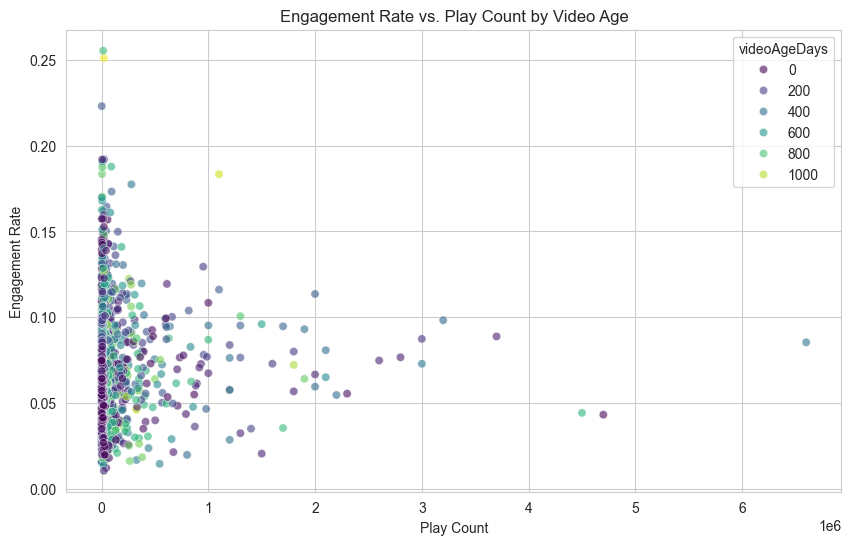

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set the style of the visualization
sns.set_style("whitegrid")

# Create a scatter plot of engagement rate vs play count with video age as the hue
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='playCount', y='engagementRate', hue='videoAgeDays', palette='viridis', alpha=0.6)

# Set the title and labels
plt.title('Engagement Rate vs. Play Count by Video Age')
plt.xlabel('Play Count')
plt.ylabel('Engagement Rate')


# Display the plot
plt.show()

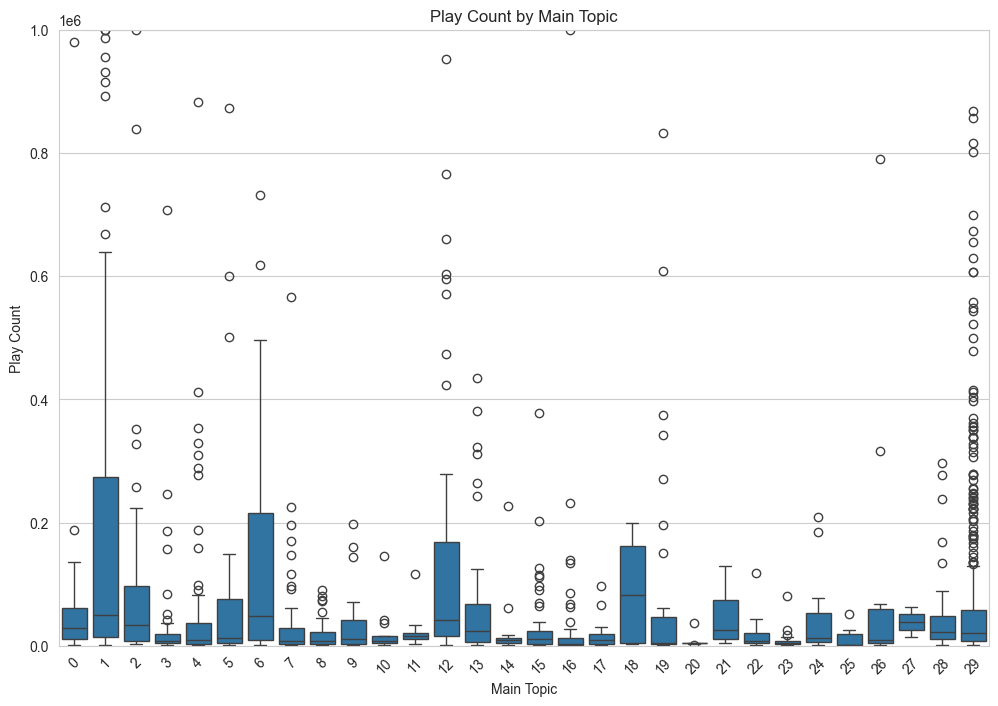

In [7]:
# Compare the Play Count to main topics (main topic on x-axis, play count on y-axis)
plt.figure(figsize=(12, 8))
sns.boxplot(data=df, x='mainTopic', y='playCount')

# Set the title and labels
plt.title('Play Count by Main Topic')
plt.xlabel('Main Topic')
plt.ylabel('Play Count')
plt.xticks(rotation=45)

# reduce y-axis to 100000
plt.ylim(0, 1000000)

# Display the plot
plt.show()

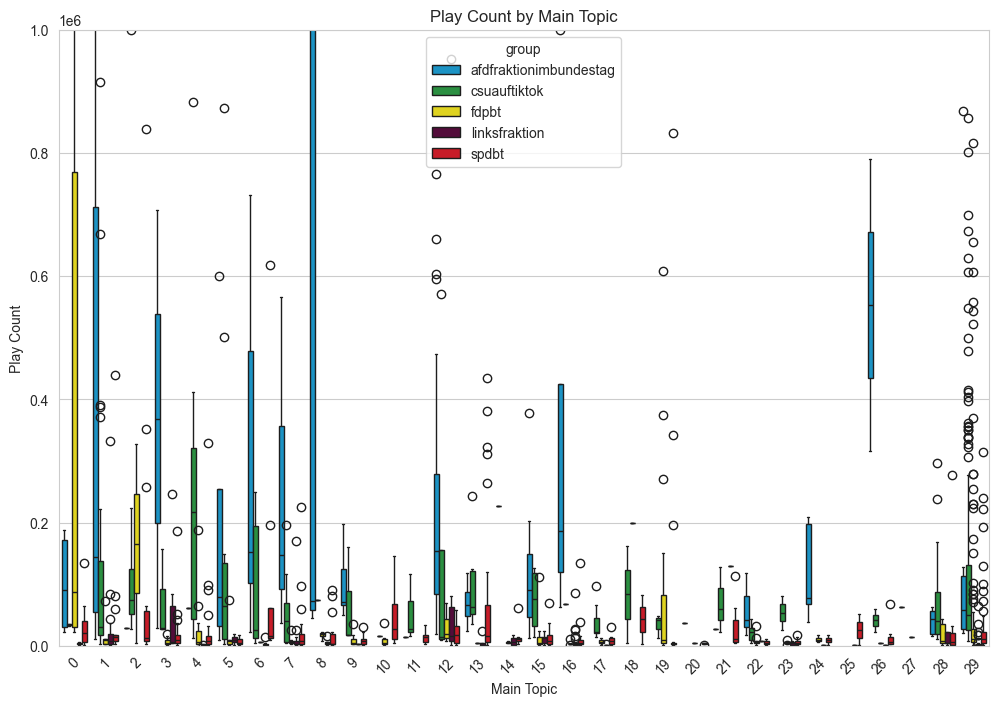

In [8]:
# Compare the Play Count to main topics (sub topic on x-axis, play count on y-axis) by group 
plt.figure(figsize=(12, 8))

import matplotlib.pyplot as plt
import seaborn as sns

# Mapping of groups to their corresponding colors
party_colors = {
    'fdpbt': '#FFEF00',  # FDP: Yellow
    'csuauftiktok': '#1AA037',  # CSU: GRÜN
    'spdbt': '#E3000F',  # SPD: Red
    'linksfraktion': '#5f003e',  # Die Linke: Magenta/Dark Red
    'afdfraktionimbundestag': '#009EE0'  # AfD: Light Blue
}

sns.boxplot(data=df, x='mainTopic', y='playCount', hue='group', palette=party_colors)

# Set the title and labels
plt.title('Play Count by Main Topic')
plt.xlabel('Main Topic')
plt.ylabel('Play Count')
plt.xticks(rotation=45)

# reduce y-axis to 100000
plt.ylim(0, 1000000)

# Display the plot
plt.show()

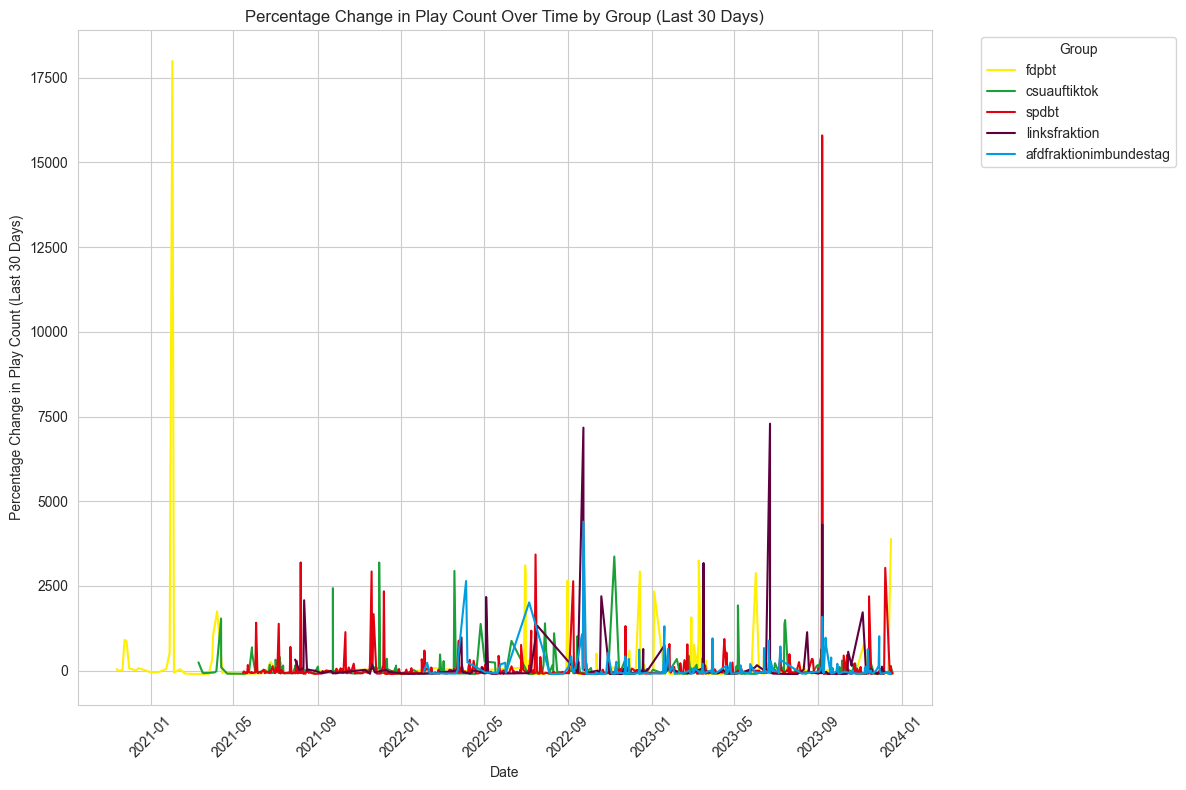

In [94]:
# Ensure the DataFrame is correctly sorted by 'group' and 'createTime' before applying any group-wise operation.
df.sort_values(by=['group', 'createTime'], inplace=True)

# Recalculate the adjusted rolling average with explicit handling
def calculate_adjusted_rolling_average(group):
    # Ensure 'playCount' is directly accessed from the passed group DataFrame.
    rolling_avg = group.rolling(window='30D', on='createTime', min_periods=1, closed='left')['playCount'].mean().shift()
    return rolling_avg


# Apply the calculation to each group.
# The transform function should directly work on 'playCount' if it exists in the DataFrame.
df['adjustedRollingAvgPlayCount_30d'] = df.groupby('group', as_index=False).apply(lambda x: calculate_adjusted_rolling_average(x)).reset_index(level=0, drop=True)

# Calculate the percentage change
df['percentageChange'] = ((df['playCount'] - df['adjustedRollingAvgPlayCount_30d']) / df['adjustedRollingAvgPlayCount_30d']) * 100


# Ensure the createTime is in datetime format for plotting
df['createTime'] = pd.to_datetime(df['createTime'])

# Ensure 'createTime' is sorted for consistent plotting
df.sort_values(by='createTime', inplace=True)

# Visualization code as provided
plt.figure(figsize=(12, 8))
sns.lineplot(data=df, x='createTime', y='percentageChange', hue='group', palette=party_colors)

plt.title('Percentage Change in Play Count Over Time by Group (Last 30 Days)')
plt.xlabel('Date')
plt.ylabel('Percentage Change in Play Count (Last 30 Days)')
plt.xticks(rotation=45)  # Improve readability of dates
plt.legend(title='Group', bbox_to_anchor=(1.05, 1), loc='upper left')  # Adjust legend position

plt.tight_layout()  # Adjust layout to make room for the legend
plt.show()


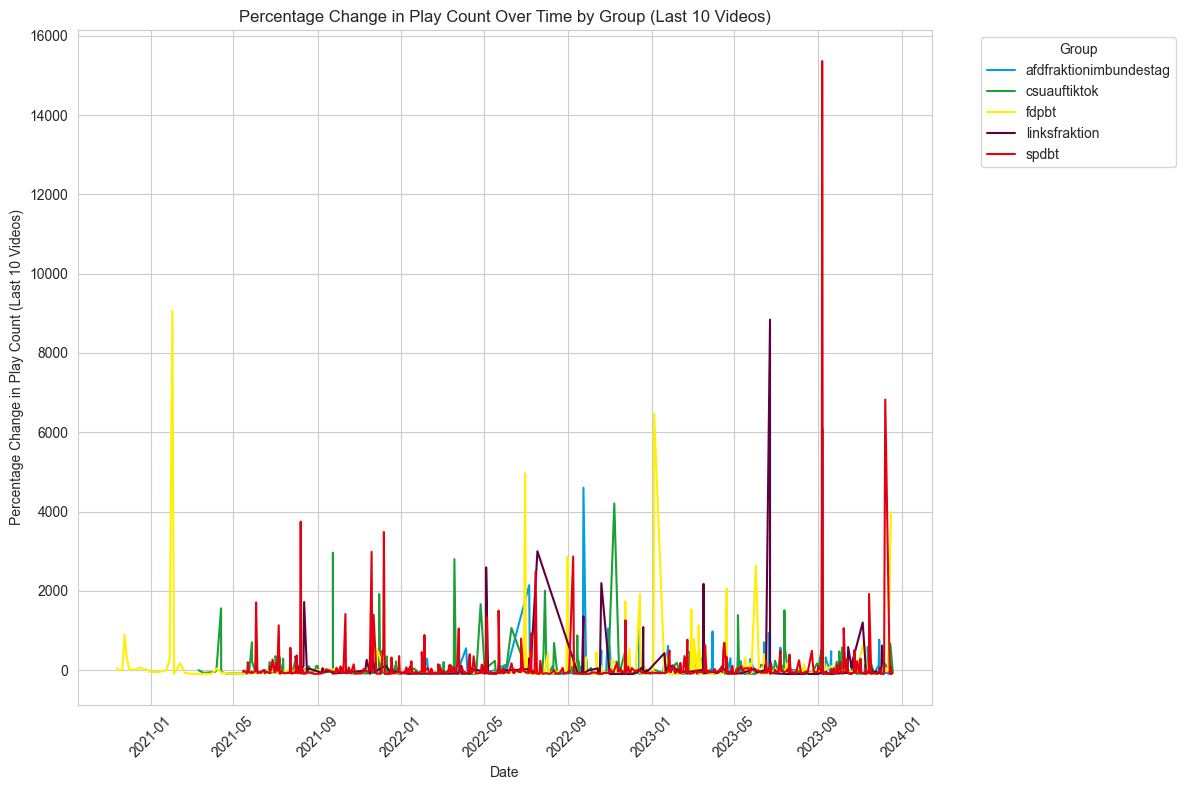

In [95]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming df is already loaded and contains 'group', 'createTime', and 'playCount' columns

# Make sure 'createTime' is a datetime column
df['createTime'] = pd.to_datetime(df['createTime'])

# Sort the DataFrame by 'group' and 'createTime' to ensure chronological order within each group
df.sort_values(by=['group', 'createTime'], inplace=True)

def calculate_adjusted_rolling_average_video_based(group):
    # Use a fixed window size of 10 for the rolling operation, calculating the median playCount of the last 10 videos
    # This calculation does not require 'createTime' to be the index or specified in the rolling call
    rolling_avg = group['playCount'].rolling(window=10, min_periods=2).mean().shift()
    return rolling_avg

# Apply the video-based rolling calculation to each group
df['adjustedRollingAvgPlayCount_10v'] = df.groupby('group', as_index=False).apply(lambda x: calculate_adjusted_rolling_average_video_based(x)).reset_index(level=0, drop=True)

# Calculate the percentage change based on the last 10 videos
df['percentageChange_10v'] = ((df['playCount'] - df['adjustedRollingAvgPlayCount_10v']) / df['adjustedRollingAvgPlayCount_10v']) * 100

# Visualization
plt.figure(figsize=(12, 8))
sns.lineplot(data=df, x='createTime', y='percentageChange_10v', hue='group', palette=party_colors)

plt.title('Percentage Change in Play Count Over Time by Group (Last 10 Videos)')
plt.xlabel('Date')
plt.ylabel('Percentage Change in Play Count (Last 10 Videos)')
plt.xticks(rotation=45)
plt.legend(title='Group', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


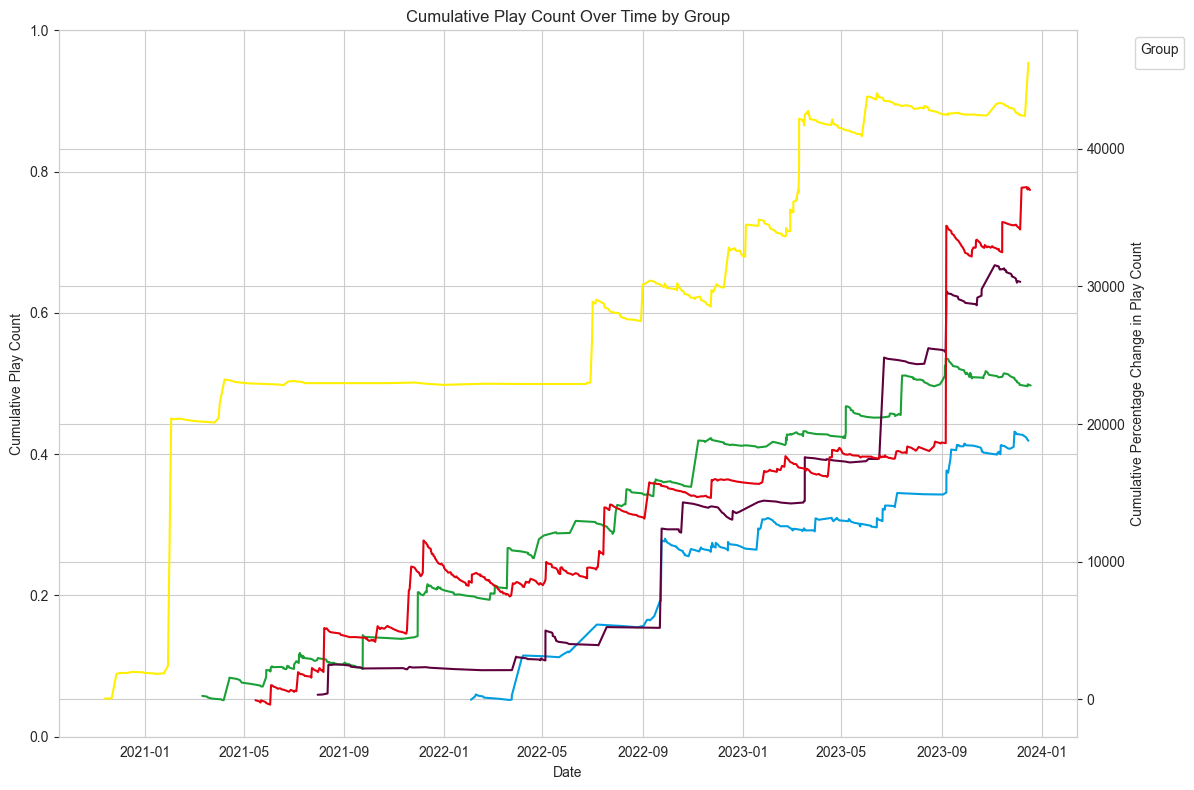

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
# visualize the cumulative pecentage change and the cumulative play count for each group over time
plt.figure(figsize=(12, 8))
# sns.lineplot(data=df, x='createTime', y='cumulativePlayCount', hue='group', palette=party_colors, legend=False)
plt.title('Cumulative Play Count Over Time by Group')
plt.xlabel('Date')
plt.ylabel('Cumulative Play Count')

# Create a second y-axis to represent the cumulative percentage change
ax2 = plt.twinx()
df['cumulativePercentageChange'] = df.groupby('group')['percentageChange'].expanding().sum().reset_index(level=0, drop=True)
sns.lineplot(data=df, x='createTime', y='cumulativePercentageChange', hue='group', palette=party_colors, legend=False, ax=ax2)
ax2.set_ylabel('Cumulative Percentage Change in Play Count')

plt.legend(title='Group', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()


<Figure size 5000x800 with 0 Axes>

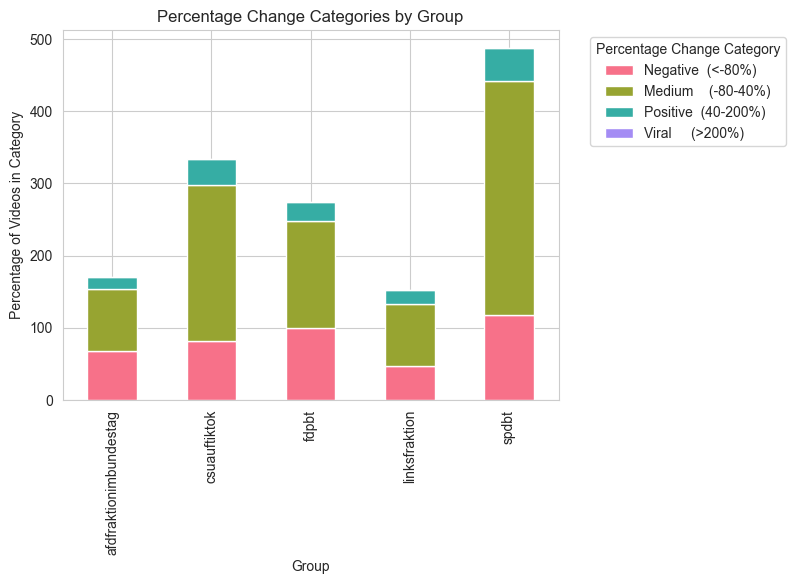

In [12]:
# count the number of positive and negative percentage changes for each group (percentageChange_10v and percentageChange)

# Define the threshold values for categorizing percentage changes
bad_threshold = -80
medium_threshold = 40
viral_threshold = 200


# percentageChange
viral_changes = df[df['percentageChange'] > viral_threshold].groupby('group').size()
positive_changes = df[(df['percentageChange'] > medium_threshold) & (df['percentageChange'] <= viral_threshold)].groupby('group').size()
medium_changes = df[(df['percentageChange'] >= bad_threshold) & (df['percentageChange'] <= medium_threshold)].groupby('group').size()
negative_changes = df[df['percentageChange'] < bad_threshold].groupby('group').size()

# percentageChange_10v
viral_changes_10v = df[df['percentageChange_10v'] > viral_threshold].groupby('group').size()
positive_changes_10v = df[(df['percentageChange_10v'] > medium_threshold) & (df['percentageChange_10v'] <= viral_threshold)].groupby('group').size()
medium_changes_10v = df[(df['percentageChange_10v'] >= bad_threshold) & (df['percentageChange_10v'] <= medium_threshold)].groupby('group').size()
negative_changes_10v = df[df['percentageChange_10v'] < bad_threshold].groupby('group').size()

# normalize by the number of used videos in each group
viral_changes = viral_changes / df['group'].value_counts()



# Create a DataFrame to combine the counts
change_counts = pd.DataFrame({
    # 'Viral (Last 10 Videos)': viral_changes_10v,
    # 'Positive (Last 10 Videos)': positive_changes_10v,
    # 'Medium (Last 10 Videos)': medium_changes_10v,
    # 'Negative (Last 10 Videos)': negative_changes_10v,
    f'Negative  (<{bad_threshold}%)': negative_changes,
    f'Medium    ({bad_threshold}-{medium_threshold}%)': medium_changes,
    f'Positive  ({medium_threshold}-{viral_threshold}%)': positive_changes,
    f'Viral     (>{viral_threshold}%)': viral_changes,
    
})

# Fill any missing values with 0
change_counts = change_counts.fillna(0)


# Visualize the counts
plt.figure(figsize=(50, 8))
change_counts.plot(kind='bar', stacked=True, color=sns.color_palette('husl', 4))

# Move the legend to the right next to the plot
plt.legend(title='Percentage Change Category', bbox_to_anchor=(1.05, 1), loc='upper left')

# Set the title and labels
plt.title('Percentage Change Categories by Group')
plt.xlabel('Group')
plt.ylabel('Percentage of Videos in Category')

# Display the plot
plt.show()

In [13]:
# calculate the average videos per 30 days per group
average_videos_per_30_days = df.groupby('group').resample('30D', on='createTime').size().groupby('group').mean()

# Display the average videos per 30 days per group
average_videos_per_30_days


group
afdfraktionimbundestag     9.086957
csuauftiktok              11.176471
fdpbt                      8.315789
linksfraktion              6.068966
spdbt                     16.750000
dtype: float64

In [29]:
# total video count
video_count = df['group'].value_counts()

# Display the total video count
video_count

# sum of all groups
video_count.sum()

# total video duration
df['duration'].sum()

# total transcript words count in all videos words per second * duration
(df['wordsPerSecond'] * df['duration']).sum()

# 

# display column names
df.columns



Index(['Unnamed: 0', 'group', 'createTime', 'textExtraCount',
       'challengesCount', 'descLength', 'publicMusic', 'collectCount',
       'commentCount', 'diggCount', 'shareCount', 'playCount', 'duration',
       'wordsPerSecond', 'mainTopic', 'subTopics', 'videoAgeDays', 'timeOfDay',
       'weekdayOfPosting', 'videoLengthCategory', 'combinedEngagementScore',
       'engagementRate', 'cumulativePlayCount', 'cumulativeDiggCount',
       'averageEngagementRate', 'rollingAvgPlayCount_last5', 'combinedTopics',
       'topicVarietyLast5', 'adjustedRollingAvgPlayCount_30d',
       'percentageChange', 'adjustedRollingAvgPlayCount_10v',
       'percentageChange_10v', 'cumulativePercentageChange'],
      dtype='object')

In [31]:
print(f"Total video count: {video_count.sum()}")
print(f"Total video duration: {df['duration'].sum()/60} minutes")
print(f"Average video duration: {df['duration'].mean()} seconds")
print(f"Total transcript words count: {(df['wordsPerSecond'] * df['duration']).sum()} words")
print(f"First video date: {df['createTime'].min()}")
print(f"Last video date: {df['createTime'].max()}")

Total video count: 1617
Total video duration: 1159.2018333333333 minutes
Average video duration: 43.0130550401979 seconds
Total transcript words count: 167246.0 words
First video date: 2020-11-12 11:22:50
Last video date: 2023-12-18 09:29:41


In [34]:
# Save the DataFrame to a CSV file seperator ; also convert everything to german format (decimal , and date format)

df.to_csv('../data/video_data_summary_features.csv', sep=';', decimal=',', date_format='%d.%m.%Y %H:%M:%S')

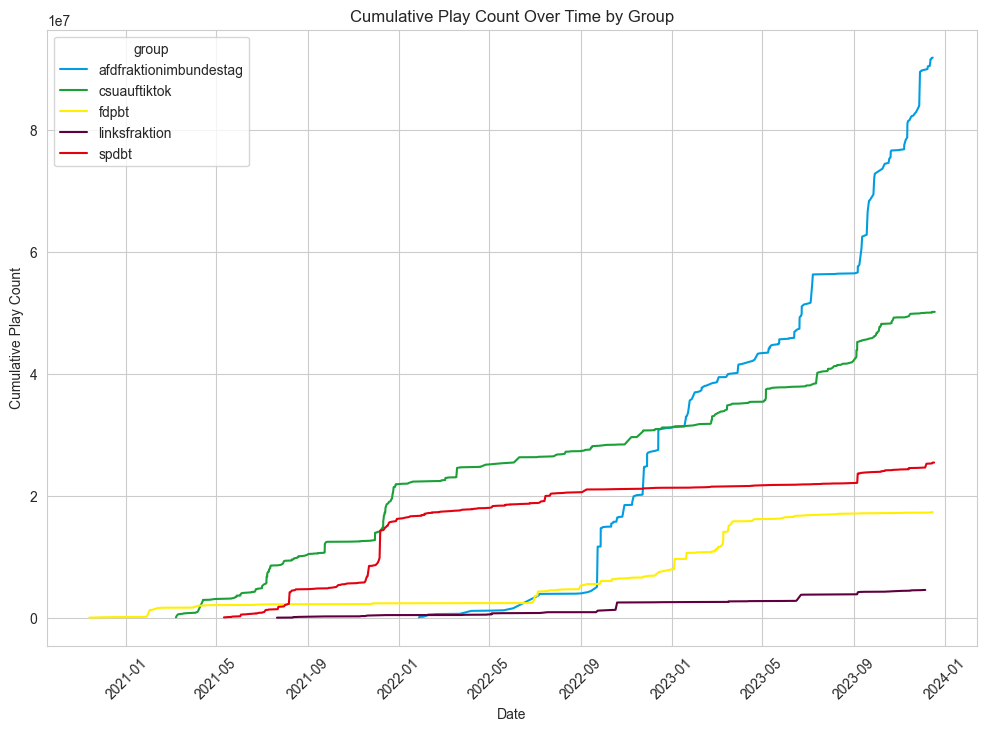

In [39]:
# Graph of cummulative play count over time
import matplotlib.pyplot as plt
import seaborn as sns

# Set the style of the visualization
sns.set_style("whitegrid")

# Create a line plot of cumulative play count over time
plt.figure(figsize=(12, 8))
sns.lineplot(data=df, x='createTime', y='cumulativePlayCount', hue='group', palette=party_colors)

# Set the title and labels
plt.title('Cumulative Play Count Over Time by Group')
plt.xlabel('Date')
plt.ylabel('Cumulative Play Count')
plt.xticks(rotation=45)  # Improve readability of dates

# Display the plot
plt.show()


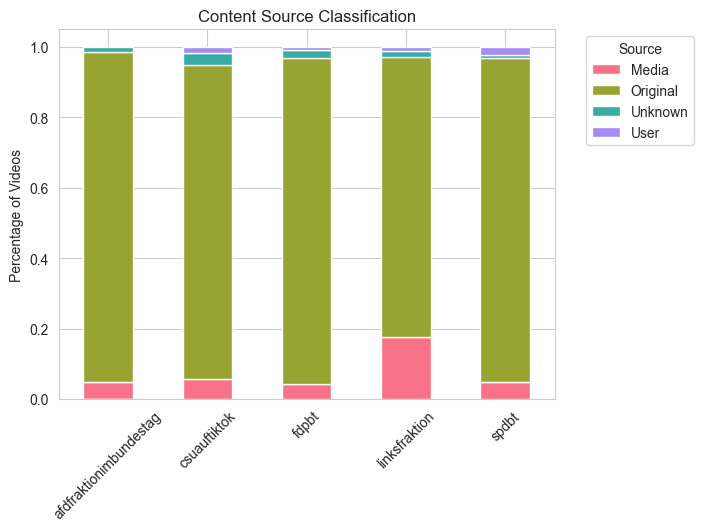

In [73]:
# Create a stacked bar plot of the percentage of videos of each category (column '1') by group

df['1'].groupby(df['group']).value_counts(normalize=True).unstack().plot(kind='bar', stacked=True, color=sns.color_palette('husl', 4))

# Set the title and labels
plt.title('Content Source Classification')
plt.xlabel('')
plt.ylabel('Percentage of Videos')
plt.xticks(rotation=45)

# change legend name to category
plt.legend(title='Source', bbox_to_anchor=(1.05, 1), loc='best')

# Display the plot
plt.show()

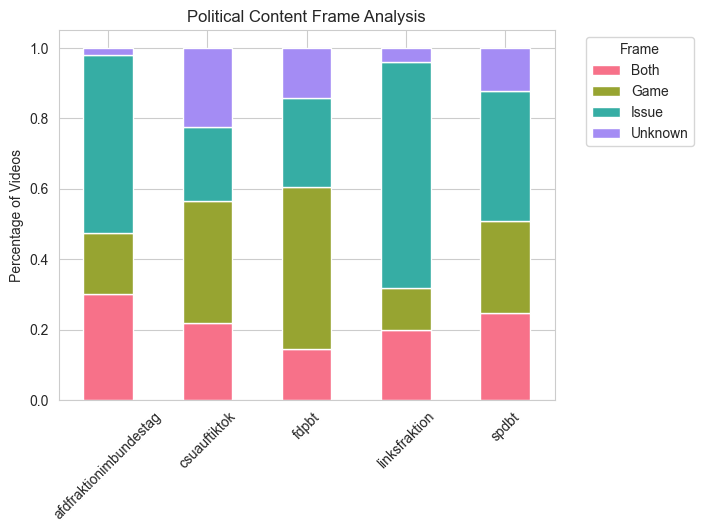

In [72]:
# Create a stacked bar plot of the percentage of videos of each category (column '1') by group

df['2'].groupby(df['group']).value_counts(normalize=True).unstack().plot(kind='bar', stacked=True, color=sns.color_palette('husl', 4))

# Set the title and labels
plt.title('Political Content Frame Analysis')
plt.xlabel('')
plt.ylabel('Percentage of Videos')
plt.xticks(rotation=45)

# change legend name to category
plt.legend(title='Frame', bbox_to_anchor=(1.05, 1), loc='best')

# Display the plot
plt.show()

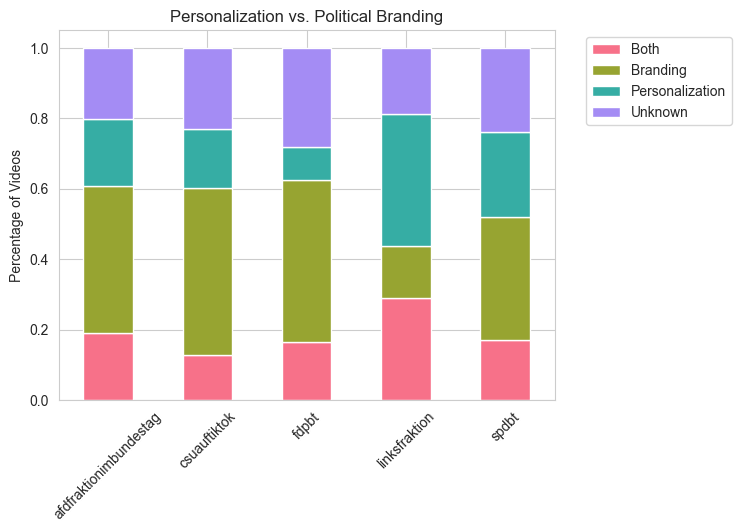

In [71]:
# Create a stacked bar plot of the percentage of videos of each category (column '1') by group

df['3'].groupby(df['group']).value_counts(normalize=True).unstack().plot(kind='bar', stacked=True, color=sns.color_palette('husl', 4))

# Set the title and labels
plt.title('Personalization vs. Political Branding')
plt.xlabel('')
plt.ylabel('Percentage of Videos')
plt.xticks(rotation=45)

# change legend name to category
plt.legend(title='', bbox_to_anchor=(1.05, 1), loc='best')

# Display the plot
plt.show()

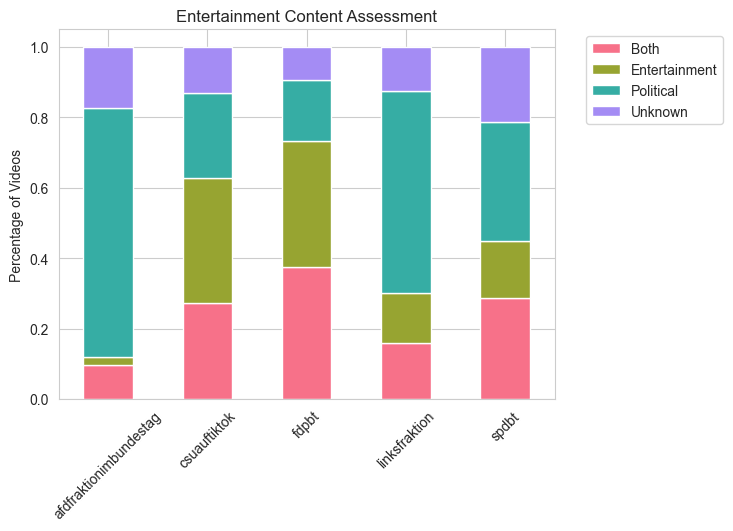

In [70]:
# Create a stacked bar plot of the percentage of videos of each category (column '1') by group

df['4'].groupby(df['group']).value_counts(normalize=True).unstack().plot(kind='bar', stacked=True, color=sns.color_palette('husl', 4))

# Set the title and labels
plt.title('Entertainment Content Assessment')
plt.xlabel('')
plt.ylabel('Percentage of Videos')
plt.xticks(rotation=45)

# change legend name to category
plt.legend(title='', bbox_to_anchor=(1.05, 1), loc='best')

# Display the plot
plt.show()

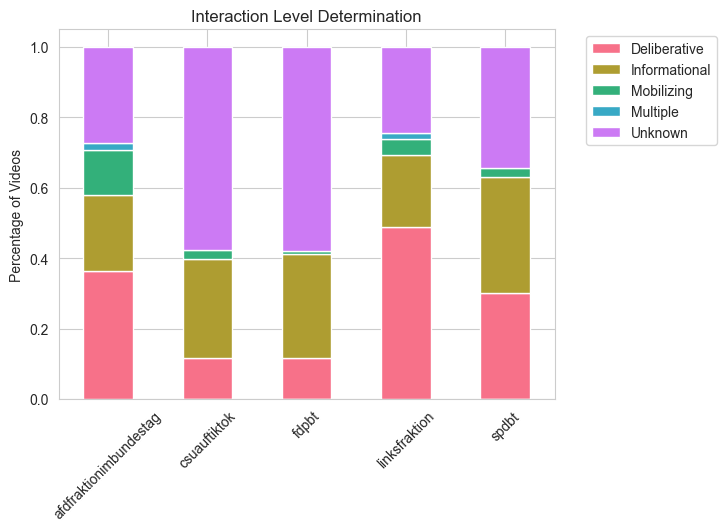

In [69]:
# Create a stacked bar plot of the percentage of videos of each category (column '1') by group

df['5'].groupby(df['group']).value_counts(normalize=True).unstack().plot(kind='bar', stacked=True, color=sns.color_palette('husl', 5))

# Set the title and labels
plt.title('Interaction Level Determination')
plt.xlabel('')
plt.ylabel('Percentage of Videos')
plt.xticks(rotation=45)

# change legend name to category
plt.legend(title='', bbox_to_anchor=(1.05, 1), loc='best')

# Display the plot
plt.show()